# TOPP-HATT

In some cases, we want to optimise an encoding without changing the underlying tree structure. For instance, we may want to use exactly the tree output from the [Bonsai Algorithm](https://ferrmion.readthedocs.io/en/latest/notebooks/bonsai.html).

`ferrmion` lets you do this with the `topphatt` algorithm.

Currently there are two slightly different implementations, 
- `ferrmion.optimize.topphatt`
- `ferrmion.core`

For more details, see our [preprint](https://arxiv.org/abs/2512.13580).

In [1]:
from ferrmion import core
from ferrmion.utils import fermionic_to_sparse_majorana
from ferrmion.core import anneal_enumerations, encode, topphatt, standard_symplectic_matrix, template_weight_distribution
from ferrmion.optimize import topphatt
from ferrmion.encode import TernaryTree
from ferrmion.hamiltonians import fill_template, molecular_hamiltonian_template


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pathlib import Path
from copy import deepcopy
import pickle


We'll start as always by loading in some one and two electron integrals.

In [2]:
# from openfermion.chem.pubchem import geometry_from_pubchem
# from openfermion.chem.molecular_data import MolecularData
# from openfermion.chem.molecular_data import spinorb_from_spatial
# import openfermionpyscf

# geometry=geometry_from_pubchem("H2O")
# mol = MolecularData(geometry=geometry, basis="sto-3g", multiplicity=1)
# mol = openfermionpyscf.run_pyscf(molecule=mol, run_scf=True)
# ones, twos = spinorb_from_spatial(mol.one_body_integrals, mol.two_body_integrals)


folder = Path.cwd().joinpath(Path("../../../python/tests/"))
with open(folder.joinpath("./data/water_1e.pkl"), 'rb') as file:
    ones = pickle.load(file)

with open(folder.joinpath("./data/water_2e.pkl"), 'rb') as file:
    twos = pickle.load(file)

twos = 0.5*twos

In [3]:
def pauli_weights(pauli_hamiltonian: dict[str, float]) -> list[float]:
    unscaled_terms = []
    scaled_terms = []
    for k, v in pauli_hamiltonian.items():
        assert v != 0
        pw = (len(k) - k.count("I")) 
        unscaled_terms.append(pw)
        scaled_terms.append(pw* np.abs(v))

    return (np.mean(unscaled_terms), np.mean(scaled_terms), len(pauli_hamiltonian))

In [ ]:

def get_topp_hatt_results(name:str, ones, twos, limit=250):
    tree = TernaryTree(ones.shape[0])
    match name:
        case "BK" | "Bravyi-Kitaev":
            tree = tree.BravyiKitaev()
        case "JW" | "Jordan-Wigner":
            tree = tree.JordanWigner()
        case "PE" | "Parity":
            tree = tree.ParityEncoding()
        case "JKMN":
            tree = tree.JKMN()

    initial_ones = deepcopy(ones)
    initial_twos = deepcopy(twos)

    print("Getting Naive result...")
    sdmeans_naive = {}
    rng = np.random.RandomState(1017)
    # ipow, sym = tree._build_symplectic_matrix()
    ipow, sym = standard_symplectic_matrix(name, tree.n_modes)
    result = pauli_weights(encode(ipow, sym, ["+-","++--"], [ones, twos]))
    print("Naive result:", result)
    sdmeans_naive["unscaled"] = result[0]
    sdmeans_naive["scaled"] = result[1]
    sdmeans_naive["length"] = result[2]


    print(f"\nGetting {limit} random results...")
    sdmeans = {}
    sdmeans = {"unscaled":[], "scaled":[], "length":[]}

    for i in range(limit):
        perm = rng.permutation(ones.shape[0])
        perm_index = np.ravel(np.column_stack((2*perm, 2*perm +1)))
        result = pauli_weights(encode(ipow[perm_index], sym[perm_index], ["+-", "++--"], [ones, twos]))
        sdmeans["unscaled"].append(result[0]) 
        sdmeans["scaled"].append(result[1])
        sdmeans["length"].append(result[2]) 
    print("Permutation Results")

    print("\nGetting Annealed result...")
    sdmeans_annealed = {}
    _, annealed_best = anneal_enumerations(molecular_hamiltonian_template(ipow, sym, True), ones, twos, temperature=ones.shape[0], initial_guess=np.array([*range(ones.shape[0])],dtype=np.uint), coefficient_weighted=True)
    print("Finished annealing.")
    perm_index = np.ravel(np.column_stack((2*annealed_best, 2*annealed_best +1)))
    print(f"Annealed Enumeration {annealed_best}: {perm_index}")
    anneal_ham = encode(ipow[perm_index], sym[perm_index], ["+-","++--"], [ones, twos])
    result = pauli_weights(anneal_ham)
    print("Annealed result:", result)
    sdmeans_annealed["unscaled"] = result[0]
    sdmeans_annealed["scaled"] = result[1]
    sdmeans_annealed["length"] = result[2]

    print("\nRunning rust TOPP-HATT...")
    if name in ["Jordan-Wigner", "Parity", "Bravyi-Kitaev", "JKMN", "JW", "BK", "PE"]:
        ipow,sym = core.topphatt_standard(name, 14, 14, ["+-","++--"], [ones, twos])
    else:
        ipow,sym = core.topphatt(14, tree.flatpack(), ["+-","++--"], [ones, twos])
        
    print("\nGetting rust TOPP-HATT result...")
    result = pauli_weights(encode(ipow, sym, ["+-","++--"],[ones,twos]))
    print("TOPP-HATT result:", result)
    
    sdmeans_topphatt = {}
    sdmeans_topphatt["unscaled"] = result[0]
    sdmeans_topphatt["scaled"] = result[1]
    sdmeans_topphatt["length"] = result[2]
    
    print("\nRunning python TOPP-HATT...")
    sparse_ham = fermionic_to_sparse_majorana(((deepcopy(ones),"+-"), (deepcopy(twos), "++--")))
    hatt_tree = topphatt(deepcopy(sparse_ham), tree=tree)
    print(f"python TOPPHATT weight {hatt_tree.pauli_weight}")
    print("Getting python TOPP-HATT result...")
    ipow, sym = hatt_tree._build_symplectic_matrix()
    result = pauli_weights(encode(ipow, sym, ["+-","++--"], [ones, twos]))
    print("Python TOPP-HATT result:", result)
    sdmeans_topphatt_py = {}
    sdmeans_topphatt_py["unscaled"] = result[0]
    sdmeans_topphatt_py["scaled"] = result[1]
    sdmeans_topphatt_py["length"] = result[2]


    color_set = {"jw":"tab:blue", "pe":"tab:orange", "bk":"tab:green", "jkmn":"tab:red", "bonsai":"tab:purple", "huffman":"tab:brown", "hatt":"tab:pink"}
    fig, ax = plt.subplots(layout="constrained")

    ax.scatter(sdmeans["unscaled"], sdmeans["scaled"], label="Randomised Permutations", marker=".", color="tab:grey", alpha=0.7)
    ax.plot(sdmeans_naive["unscaled"], sdmeans_naive["scaled"], marker="D", color="tab:red", mec="k", markersize=8)
    ax.plot(sdmeans_annealed["unscaled"], sdmeans_annealed["scaled"], marker="o", color="tab:orange", mec="k", markersize=8)
    ax.plot(sdmeans_topphatt["unscaled"], sdmeans_topphatt["scaled"], marker="P", color="tab:green", mec="k", markersize=8)
    ax.plot(sdmeans_topphatt_py["unscaled"], sdmeans_topphatt_py["scaled"], marker="P", color="tab:blue", mec="k", markersize=8)

    # where some data has already been plotted to ax
    handles, labels = plt.gca().get_legend_handles_labels()
    # manually define a new patch 
    naive_legend = mlines.Line2D([], [], label='Naive Enumeration', marker="D", linestyle="", color="tab:red", mec="k", markersize=8)
    annealed_legend = mlines.Line2D([], [], label='Annealed Best', marker="o", linestyle="",color="tab:orange", mec="k", markersize=8)
    topphatt_legend = mlines.Line2D([], [], label='TOPP-HATT-Rust', marker="P", linestyle="",color="tab:green", mec="k", markersize=8)
    topphatt_py_legend = mlines.Line2D([], [], label='TOPP-HATT-Python', marker="P", linestyle="",color="tab:blue", mec="k", markersize=8)

    assert np.all(initial_ones == ones)
    assert np.all(initial_twos == twos)

    # handles is a list, so append manual patch
    handles.extend([
                    naive_legend,
                    annealed_legend, 
                    topphatt_legend,
                    topphatt_py_legend,
                    ])

    ax.set_xlabel("unscaled pauli-weight")
    ax.set_ylabel("coefficient scaled pauli-weight")
    ax.set_title(f"{name} Encodings of $H_2 O$:$STO-3G$")
    fig.legend(handles=handles, loc="outside lower center", ncols=len(handles)//2)
    fig.show()



Getting Naive result...
Naive result: (np.float64(7.04102096627165), np.float64(0.17447814798520664), 1097)

Getting 250 random results...
Permutation Results
None

Getting Annealed result...
Finished annealing.
Annealed Enumeration [ 9  1  7  3 11 13  5  8  0  2 10  6 12  4]: [18 19  2  3 14 15  6  7 22 23 26 27 10 11 16 17  0  1  4  5 20 21 12 13
 24 25  8  9]
Annealed result: (np.float64(6.123974475843209), np.float64(0.15131331935457018), 1097)

Running rust TOPP-HATT...

Getting rust TOPP-HATT result...
TOPP-HATT result: (np.float64(4.951686417502279), np.float64(0.1248608816289167), 1097)

Running python TOPP-HATT...
python TOPPHATT weight 2122
Getting python TOPP-HATT result...
Python TOPP-HATT result: (np.float64(4.951686417502279), np.float64(0.1248608816289167), 1097)


/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_10879/1026816339.py:116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


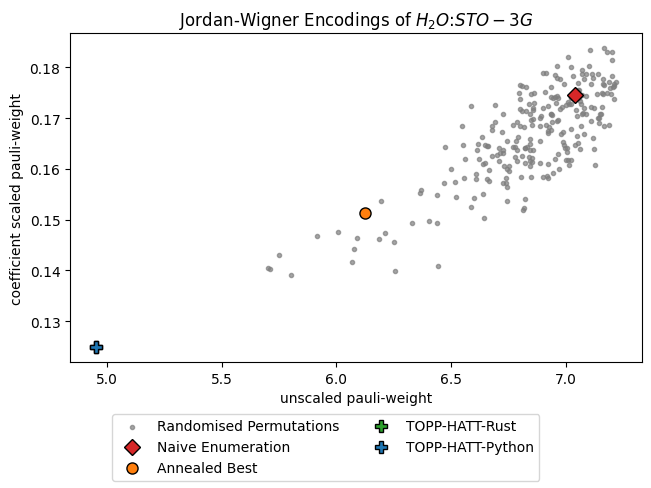

In [5]:
get_topp_hatt_results("Jordan-Wigner", ones, twos)


Getting Naive result...
Naive result: (np.float64(7.2278942570647216), np.float64(0.23427226940017873), 1097)

Getting 250 random results...
Permutation Results
None

Getting Annealed result...
Finished annealing.
Annealed Enumeration [ 6 10  2  0  4 12  9  8 13  5  7 11  3  1]: [12 13 20 21  4  5  0  1  8  9 24 25 18 19 16 17 26 27 10 11 14 15 22 23
  6  7  2  3]
Annealed result: (np.float64(6.969917958067457), np.float64(0.23488560968273467), 1097)

Running rust TOPP-HATT...

Getting rust TOPP-HATT result...
TOPP-HATT result: (np.float64(5.3965360072926165), np.float64(0.19473113010751533), 1097)

Running python TOPP-HATT...
python TOPPHATT weight 2370
Getting python TOPP-HATT result...
Python TOPP-HATT result: (np.float64(5.3965360072926165), np.float64(0.19473113010751533), 1097)


/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_10879/1026816339.py:116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


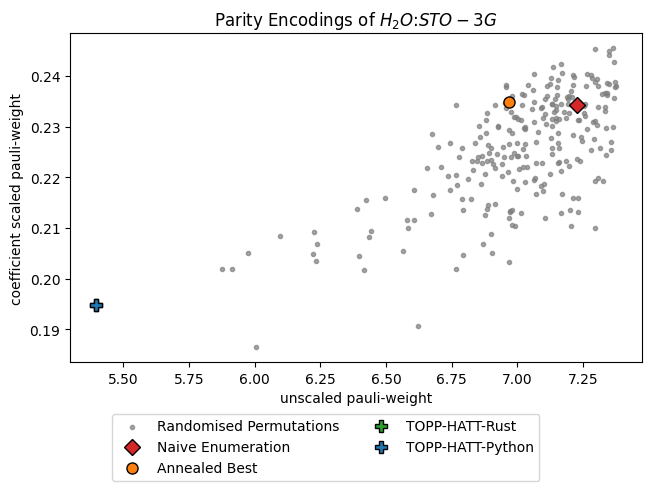

In [6]:
get_topp_hatt_results("Parity", ones, twos)


Getting Naive result...
Naive result: (np.float64(6.177757520510483), np.float64(0.26610129536293825), 1097)

Getting 250 random results...
Permutation Results
None

Getting Annealed result...
Finished annealing.
Annealed Enumeration [ 8 11  7  5 10  6  4  9  2  0  1  3 12 13]: [16 17 22 23 14 15 10 11 20 21 12 13  8  9 18 19  4  5  0  1  2  3  6  7
 24 25 26 27]
Annealed result: (np.float64(6.2333637192342755), np.float64(0.18751568654954), 1097)

Running rust TOPP-HATT...

Getting rust TOPP-HATT result...
TOPP-HATT result: (np.float64(5.811303555150411), np.float64(0.23695441085543115), 1097)

Running python TOPP-HATT...
python TOPPHATT weight 1826
Getting python TOPP-HATT result...
Python TOPP-HATT result: (np.float64(5.814949863263446), np.float64(0.21165745818288678), 1097)


/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_10879/1026816339.py:116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


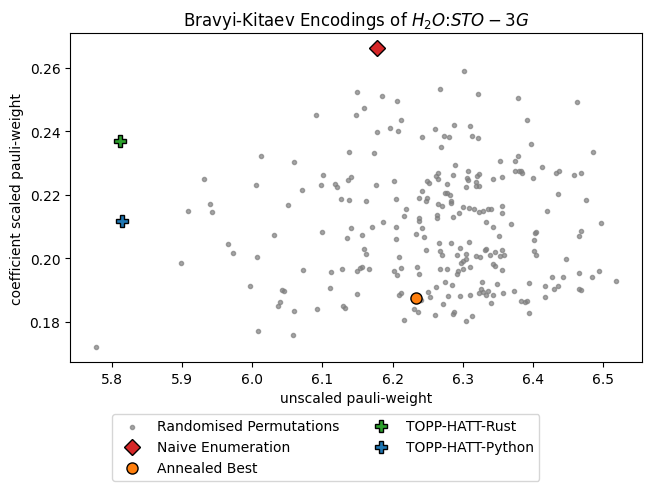

In [7]:
get_topp_hatt_results("Bravyi-Kitaev", ones, twos)

Getting Naive result...
Naive result: (np.float64(6.050136736554239), np.float64(0.25305831971787507), 1097)

Getting 250 random results...
Permutation Results
None

Getting Annealed result...
Finished annealing.
Annealed Enumeration [13  6 12 11 10  2  5  1  4  9  7  3  8  0]: [26 27 12 13 24 25 22 23 20 21  4  5 10 11  2  3  8  9 18 19 14 15  6  7
 16 17  0  1]
Annealed result: (np.float64(6.22971741112124), np.float64(0.17761337158388407), 1097)

Running rust TOPP-HATT...

Getting rust TOPP-HATT result...
TOPP-HATT result: (np.float64(5.73746581586144), np.float64(0.1934362473174096), 1097)

Running python TOPP-HATT...
python TOPPHATT weight 2102
Getting python TOPP-HATT result...
Python TOPP-HATT result: (np.float64(5.726526891522334), np.float64(0.16671315141927423), 1097)


/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_10879/1026816339.py:116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


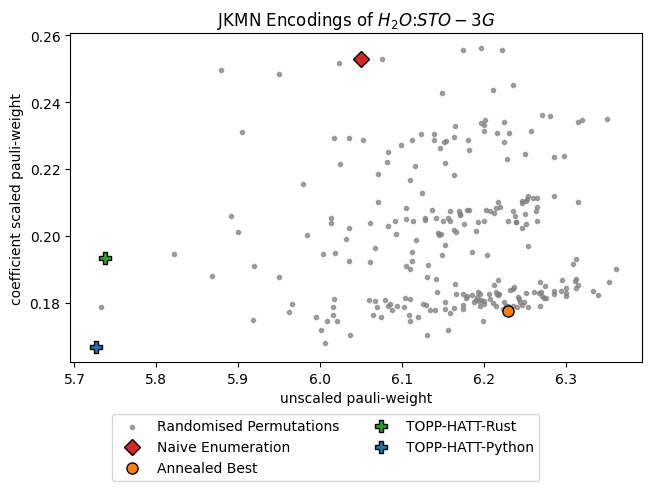

In [8]:
get_topp_hatt_results("JKMN", ones, twos)